# Interpretabilidad de modelos de clasificación

> Aplicando la técnica GradCAM a un modelo de clasificación de imágenes creado con FastAI.

- toc: true
- badges: true
- comments: true
- categories: [practica]
- image: images/chart-preview.png

En este notebook se muestra cómo crear mapas de activación para visualizar las decisiones tomadas por un modelo de clasificación de imágenes. Esta técnica está basada en el trabajo ["Grad-CAM: Why Did You Say That? Visual Explanations from Deep Networks via Gradient-based Localization"](https://arxiv.org/abs/1611.07450).

Para ello vamos a reutilizar nuestro modelo de la práctica 1 creado con la librería [fastAI](https://www.fast.ai/).

En esta práctica vamos a hacer un uso intensivo de la GPU, así que es importante activar su uso desde la opción Configuración del cuaderno del menú Editar (esta opción debería estar habilitada por defecto, pero es recomendable que lo compruebes).


## Pasos previos

En primer lugar debemos entrenar un modelo como vimos en la práctica 1. A continuación se dan los pasos explicados en dicha práctica.

## Librerías

Comenzamos descargando la última versión de la librería FastAI. Al finalizar la instalación deberás reiniciar el kernel (menú Entorno de ejecución -> Reiniciar Entorno de ejecución).

In [1]:
!pip install fastai -Uq

A continuación, cargamos aquellas librerías que son necesarias.

In [2]:
from fastai.vision.all import *

## Dataset

Para esta práctica vamos a usar como ejemplo de dataset el [Intel Image Classification dataset](https://www.kaggle.com/puneet6060/intel-image-classification). Este dataset consta de imágenes de tamaño 150x150 distribuidas en 6 categorías (buildings, forest, glacier, mountain, sea, street). Los siguientes comandos descargan y descomprimen dicho dataset.

In [3]:
!wget https://unirioja-my.sharepoint.com/:u:/g/personal/joheras_unirioja_es/EbMVHqKMSnNHh6I0-4-QWdQBlVDKz2Uz5Ky73zc5tHGofg?download=1 -O IntelImageClassification.zip
!unzip IntelImageClassification.zip

Streaming output truncated to the last 5000 lines.
  inflating: IntelImageClassification/train/mountain/16901.jpg  
  inflating: IntelImageClassification/train/mountain/16904.jpg  
  inflating: IntelImageClassification/train/mountain/16962.jpg  
  inflating: IntelImageClassification/train/mountain/16991.jpg  
  inflating: IntelImageClassification/train/mountain/17004.jpg  
  inflating: IntelImageClassification/train/mountain/17019.jpg  
  inflating: IntelImageClassification/train/mountain/17102.jpg  
  inflating: IntelImageClassification/train/mountain/17226.jpg  
  inflating: IntelImageClassification/train/mountain/17234.jpg  
  inflating: IntelImageClassification/train/mountain/17240.jpg  
  inflating: IntelImageClassification/train/mountain/17339.jpg  
  inflating: IntelImageClassification/train/mountain/17379.jpg  
  inflating: IntelImageClassification/train/mountain/17387.jpg  
  inflating: IntelImageClassification/train/mountain/17424.jpg  
  inflating: IntelImageClassification/t

Vamos a explorar el contenido de este dataset. Para ello vamos a crear un objeto [Path](https://docs.python.org/3/library/pathlib.html) que apunta al directorio que acabamos de crear.

In [4]:
path = Path('IntelImageClassification/')

Vemos que nuestro dataset consta de dos carpetas llamadas `train` y `test`. Recordar que es importante hacer la partición del dataset en dos conjuntos distintos, para luego poder evaluarlo correctamente. Podemos ahora crear objetos `path` que apunten respectivamente a nuestro conjunto de entrenamiento y a nuestro conjunto de test.

In [5]:
trainPath = path/'train'
testPath = path/'test'

## Cargando el dataset

A continuación vamos a mostrar cómo se carga el dataset para poder posteriormente crear nuestro modelo. Este proceso se hace en dos pasos. Primero se construye un objeto `DataBlock` y a continuación se construye un objeto `DataLoader` a partir del `DataBlock`. Tienes más información sobre estos objetos en la documentación de [FastAI](https://docs.fast.ai/tutorial.datablock.html).

### Datablock

Comenzamos construyendo el objeto `DataBlock`. A continuación explicaremos cada una de sus componentes.

In [6]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(valid_pct=0.2,seed=42),
                 get_y=parent_label,
                 item_tfms = Resize(256),
                 batch_tfms=aug_transforms(size=128,min_scale=0.75))

### Dataloader

Pasamos ahora a construir nuestro `DataLoader` que se construye a partir del `DataBlock` construido anteriormente indicándole el path donde se encuentran nuestras imágenes. Además podemos configurar el `DataLoader` indicándole el tamaño del batch que queremos utilizar. Al trabajar con GPUs es importante que usemos batches de tamaño 2^n para optimizar el uso de la GPU.

In [7]:
dls = db.dataloaders(trainPath,bs=128)

## Entrenando el modelo

Pasamos ahora a construir y entrenar nuestro modelo. Pero antes vamos a definir una serie de *callbacks*.

In [8]:
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='modelResnet18')
]

Además de estos tres callbacks utilizaremos otro que nos servirá para acelerar el entrenamiento de nuestros modelos usando [*mixed precision*](https://docs.fast.ai/callback.fp16.html).

## Construyendo el modelo

A continuación construimos nuestro modelo, un objeto de la clase `Learner`, utilizando el método `cnn_learner` que toma como parámetros el `DataLoader`, la arquitectura que queremos entrenar (en nuestro caso un `resnet18`), la métrica que usaremos para evaluar nuestro modelo (esta evaluación se hace sobre el conjunto de validación, y en nuestro caso será la *accuracy*), y los callbacks. Notar que en la instrucción anterior incluimos la transformación del modelo a *mixed precision*.

In [9]:
learn = cnn_learner(dls,resnet18,metrics=accuracy,cbs=callbacks).to_fp16()

/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 173MB/s]


epoch,train_loss,valid_loss,accuracy,time
0,1.062086,0.421252,0.866358,00:55


Better model found at epoch 0 with valid_loss value: 0.42125204205513.


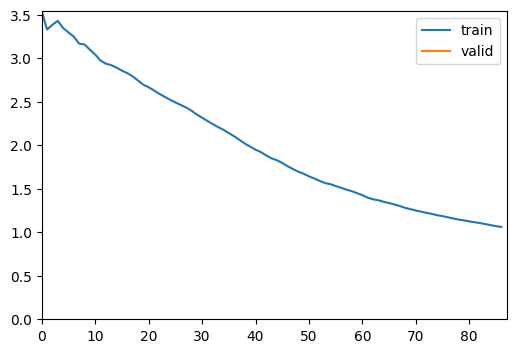

epoch,train_loss,valid_loss,accuracy,time
0,0.479972,0.320878,0.900927,01:07


Better model found at epoch 0 with valid_loss value: 0.32087835669517517.


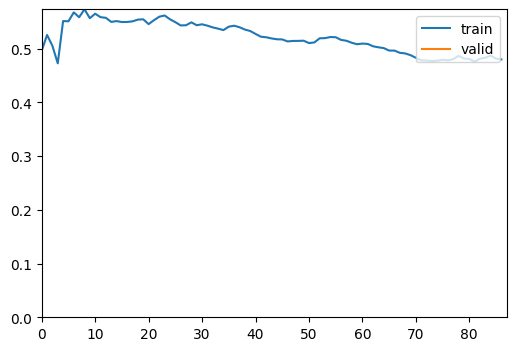

In [10]:
learn.fine_tune(10,base_lr=1e-3)

## Gradient CAM

El mapa de activación de clases (en inglés, *class activation map* o CAM) usa la salida de la última capa confolucional junto con las predicciones del modelo para producir un mapa de valor que nos ayuda a visualizar porqué el modelo tomo la decisión.

Para construir los mapas de activación, vamos a necesitar acceder a las activaciones dentro del modelo. Para ello vamos a usar los `hooks` que permiten introducir código en los calculos de propagación hacia adelante y hacia atrás del modelo. Es posible agregar un hook a cualquier capa del modelo, y este será ejecutado al calcular las salidas (*forward hook*) o durante el proceso de backpropagation (*backward hook*). Un forward hook es una función que toma tres cosas: un modulo (la arquitectura de la red), la entrada del modulo y su salida. Definimos a continuación dos hooks (uno forward y otro backward) que nos permitirán acceder a las activaciones del modelo. Una descripción más detallada de estos hooks puede verse en la [librería FastAI](https://github.com/fastai/fastbook/blob/master/18_CAM.ipynb).

In [11]:
class Hook():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)
    def hook_func(self, m, i, o): self.stored = o.detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

In [12]:
class HookBwd():
    def __init__(self, m):
        self.hook = m.register_backward_hook(self.hook_func)
    def hook_func(self, m, gi, go): self.stored = go[0].detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

A continuación elegimos la clase de la cual queremos extraer el mapa de activación. Para ello vamos a cargar una imagen, lo cargamos como un batch de datos, y vemos la predicción devuelta por el modelo, y utilizar dicha clase.

('mountain', tensor(3), tensor([0.0105, 0.0008, 0.0495, 0.7780, 0.1558, 0.0054]))


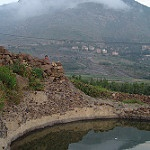

In [13]:
img = PILImage.create('IntelImageClassification/test/mountain/20058.jpg')
x, = first(dls.test_dl([img]))
print(learn.predict(img))
img

En este caso, la clase es montaña cuyo índice es 3.

In [14]:
cls = 3

Ahora para la clase cuyo índice es 3 atrapamos los descriptores de la última capa convolucional y calculamos los gradientes de las salidas de activación de la clase montaña.

In [15]:
with HookBwd(learn.model[0]) as hookg:
    with Hook(learn.model[0]) as hook:
        output = learn.model.eval()(x.cuda())
        act = hook.stored
    output[0,cls].backward()
    grad = hookg.stored

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Los pesos que nos interesan son la media de los gradientes de los descriptores, y esto lo podemos calcular del siguiente modo.

In [16]:
w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)

Por último podemos visualizar el mapa del calor usando el siguiente código.

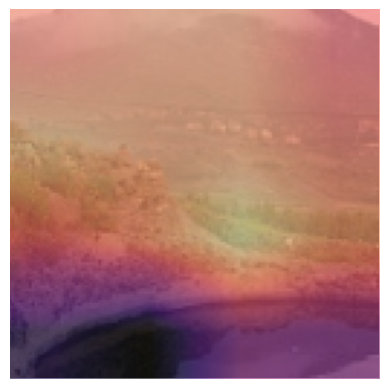

In [17]:
x_dec = TensorImage(dls.train.decode((x,))[0][0])
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,x.shape[2],x.shape[3],0),
              interpolation='bilinear', cmap='magma');

Es posible hacer lo mismo no solo con la última capa convolucional de la red, sino con cualquier otra de las capas, por ejemplo con la penultima capa del modelo.

In [18]:
with HookBwd(learn.model[0][-2]) as hookg:
    with Hook(learn.model[0][-2]) as hook:
        output = learn.model.eval()(x.cuda())
        act = hook.stored
    output[0,cls].backward()
    grad = hookg.stored

w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)

Y volvemos a realizar la visualización.

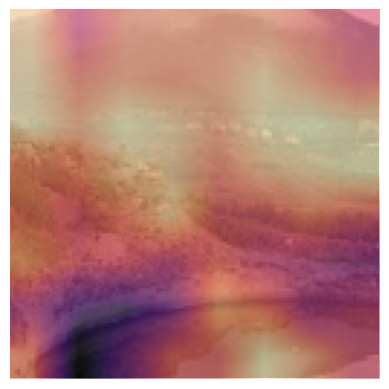

In [19]:
x_dec = TensorImage(dls.train.decode((x,))[0][0])
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,x.shape[2],x.shape[3],0),
              interpolation='bilinear', cmap='magma');

También podemos utilizar la librería captum para aplicar técnicas de interpretabilidad. Para ello, lo primero, instalamos las librerías necesarias.

In [20]:
!pip install captum -Uq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.0 MB/s eta 0:00:00


Cargamos las librerías necesarias.

In [22]:
from matplotlib.colors import LinearSegmentedColormap

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

Veámos cómo utilizar dos técnicas que son Gradient-based attribution y Occlusion-based attribution.

Gradient-based attribution.

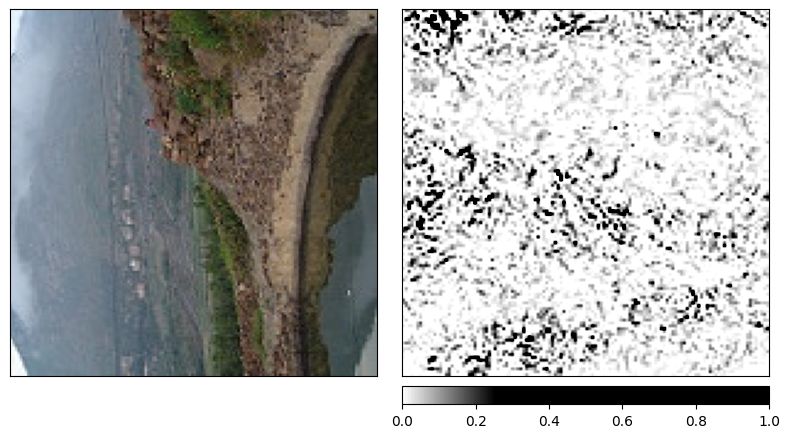

In [24]:
integrated_gradients = IntegratedGradients(learn.model)
attr_ig = integrated_gradients.attribute(x, target=0, n_steps=1)

transposed_attr_ig = np.transpose(attr_ig.to("cpu").squeeze().numpy(), (1,2,0))
transposed_image = np.transpose(np.array(img), (1,0,2))

default_cmap = LinearSegmentedColormap.from_list('custom blue',
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr_multiple(transposed_attr_ig,
                                      transposed_image,
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

Occlusion-based attribution.

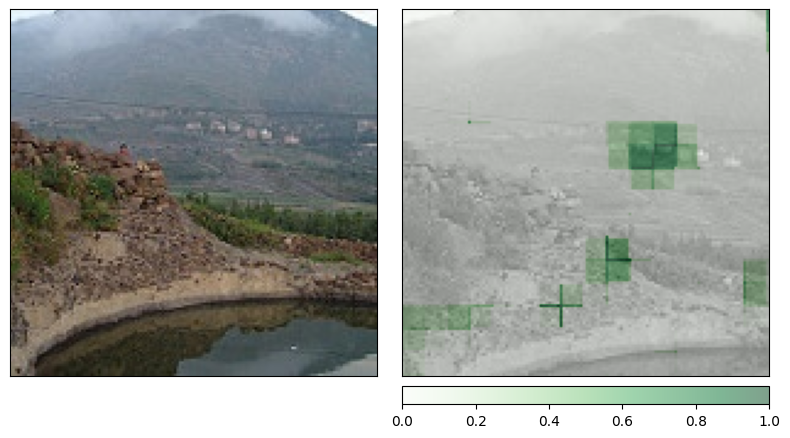

In [25]:
occlusion = Occlusion(learn.model)
attr_occ = occlusion.attribute(x,
                               strides = (3,8, 8),
                               target=0,
                               sliding_window_shapes=(3,15, 15),
                               baselines=0)

_ = viz.visualize_image_attr_multiple(np.transpose(attr_occ.to('cpu').squeeze().numpy(), (1,2,0)),
                                      img,
                                      ["original_image", "blended_heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )
